# Защита персональных данных клиентов <a id="intro"></a>

Необходимо защитить данные клиентов страховой компании «Хоть потоп». Разработаем такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию. Обоснуем корректность его работы.

Преобразование данных для защиты не должно отразиться на качестве моделей машинного обучения.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Умножение-матриц" data-toc-modified-id="Умножение-матриц-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Умножение матриц</a></span></li><li><span><a href="#Алгоритм-преобразования" data-toc-modified-id="Алгоритм-преобразования-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Алгоритм преобразования</a></span></li><li><span><a href="#Проверка-алгоритма" data-toc-modified-id="Проверка-алгоритма-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка алгоритма</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

## Загрузка данных

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("insurance.csv")

In [3]:
data.head(),data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


(   Пол  Возраст  Зарплата  Члены семьи  Страховые выплаты
 0    1     41.0   49600.0            1                  0
 1    0     46.0   38000.0            1                  1
 2    0     29.0   21000.0            0                  0
 3    0     21.0   41700.0            2                  0
 4    1     28.0   26100.0            0                  0,
 None)

In [4]:
data.isna().sum()

Пол                  0
Возраст              0
Зарплата             0
Члены семьи          0
Страховые выплаты    0
dtype: int64

Пропусков нет.

In [5]:
data[data.duplicated()]

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
281,1,39.0,48100.0,1,0
488,1,24.0,32900.0,1,0
513,0,31.0,37400.0,2,0
718,1,22.0,32600.0,1,0
785,0,20.0,35800.0,0,0
...,...,...,...,...,...
4793,1,24.0,37800.0,0,0
4902,1,35.0,38700.0,1,0
4935,1,19.0,32700.0,0,0
4945,1,21.0,45800.0,0,0


Дубликаты нам не так страшны, оставим данные как есть.

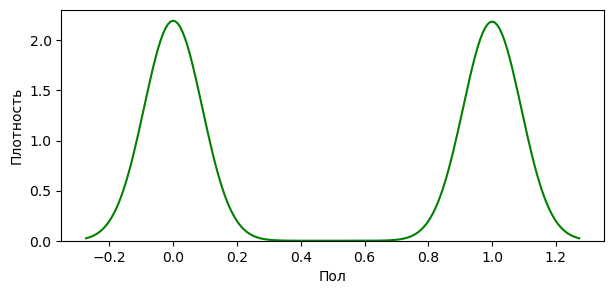

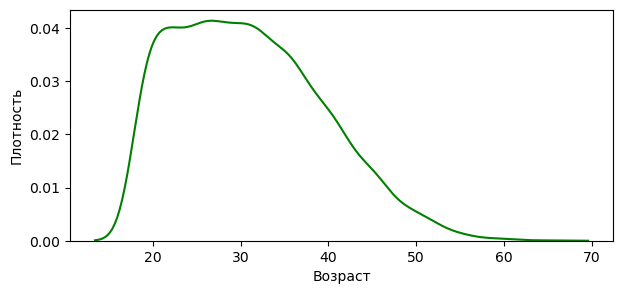

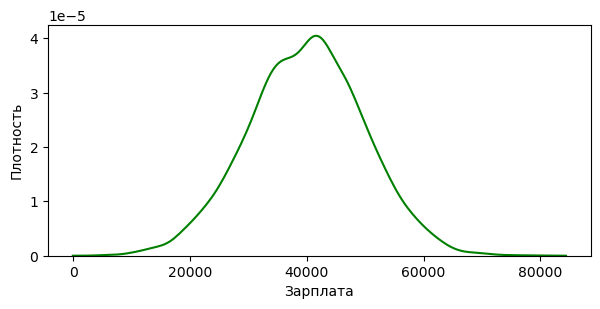

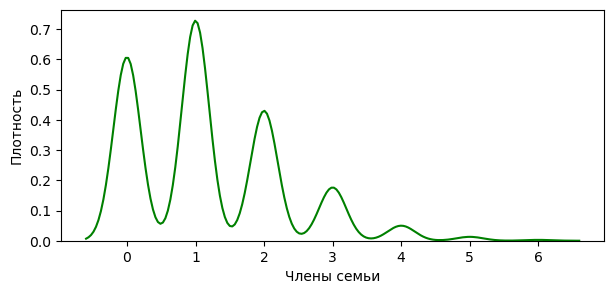

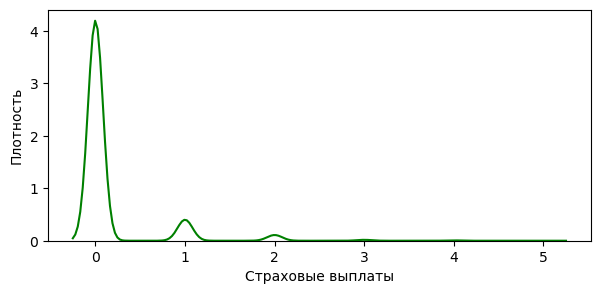

In [6]:
for col in data.columns:
    plt.subplots(1, figsize=(7, 3))
    sns.kdeplot(data[col], color="green", multiple="layer")
    plt.ylabel("Плотность")
    plt.show()

- Основная масса клиентов от 20 до 35-40 лет;
- Среднемесячная зарплата 40 000 руб.;
- В семье клиентов, как правило, до 2 чел.;
- Страховые выплаты нечастые.

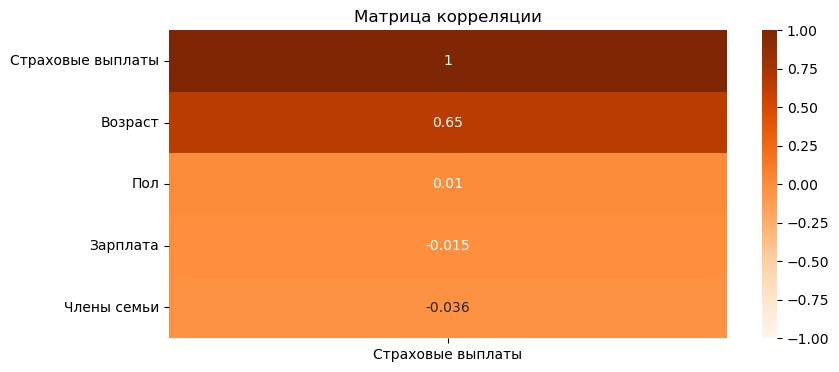

In [7]:
corr_matrix = data.corr()[["Страховые выплаты"]].sort_values("Страховые выплаты",ascending=False)

plt.figure(figsize = (9, 4))
sns.heatmap(corr_matrix,
            vmin=-1, 
            vmax=1,
            annot=True,
            cmap="Oranges")
plt.title("Матрица корреляции")
plt.show()

Между страховой выплатой и возрастом клиентов присутствует прямая линейная связь, с ростом возраста клиентов растут случаи со страховыми выплатами. Можно сказать, что остальные столбцы практически бесполезны, на обучение модели признаки пол, зарплата, члены семьи не отобразятся никак.

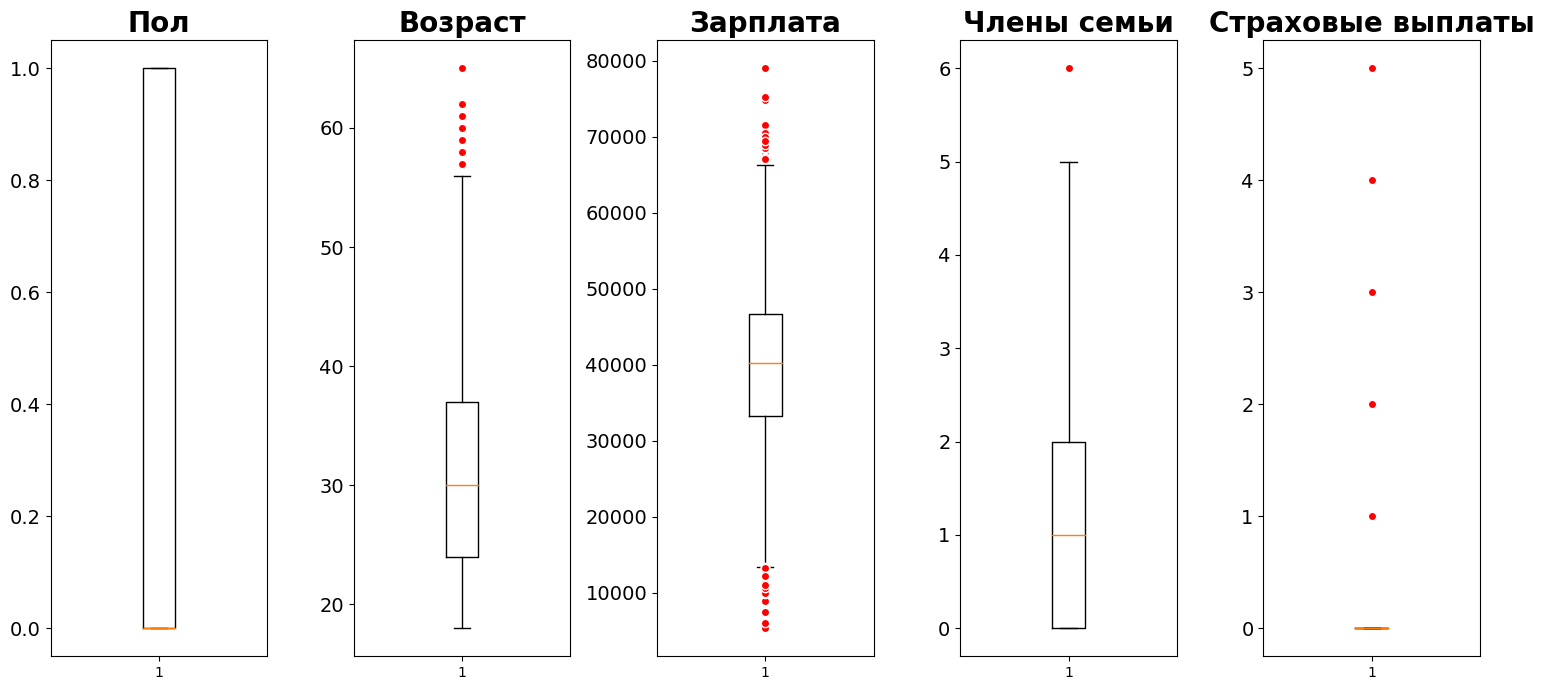

In [8]:
red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')
fig, axs = plt.subplots(1, len(data.columns), figsize=(15,7))

for i, ax in enumerate(axs):
    ax.boxplot(data.iloc[:, i], flierprops=red_circle)
    ax.set_title(data.columns[i], fontsize=20,  fontweight='bold')
    ax.tick_params(axis='y',labelsize=14)
                            
plt.tight_layout()

Данные не сильно шумные.

[В начало](#intro)

## Умножение матриц

**Обозначения:**

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

**Вспомним свойства умножения матриц:**
- транспонирование произведения матриц равно произведению транспонированных матриц в обратном порядке.

$$
(AB)^T = B^TA^T
$$

- обратная матрица из произведения матриц равна произведению обратных матриц в обратном порядке.

$$
(AB)^{-1} = B^{-1}A^{-1}
$$

- произведение матрицы на свою обратную матрицы дает в результате единичную матрицу, порядок при этом не важен.

$$
AA^{-1} = A^{-1}A = E
$$

- произведение матрицы на единичную (или наоборот) дает первоначальную матрицу, порядок также не важен.

$$
AE= EA = A
$$

Умножим нашу матрицу признаков $X$ на матрицу $P$. Тогда наша новая формула весов будет иметь следующий вид:

$$
w_{new} = ((XP)^T(XP))^{-1} (XP)^T y
$$

Используя 1-ое свойство произведения матриц, раскроем скобки.

$$
w_{new} = (P^TX^TXP)^{-1}P^TX^Ty
$$

Используя 2-ое свойство произведения матриц, раскроем скобки.

$$
w_{new} = P^{-1}X^{-1}(X^{T})^{-1}(P^{T})^{-1}P^TX^Ty
$$

Используя 3-ье и 4-ое свойства произведения матриц сокращает $(P^{T})^{-1}P^T$. Перепишем с учетом этого нашу формулу.

$$
w_{new} = P^{-1}X^{-1}(X^{T})^{-1}X^Ty
$$

Используем 2-ое свойство произведения матриц в обратном порядке.

$$
w_{new} = P^{-1}(X^{T}X)^{-1}X^Ty
$$

Если внимательно посмотреть, то часть формулы можно заменить изначальной формулой обучения.

$$
w_{new} = P^{-1}w
$$

С весами разобрались, дальше переходим в нашу формулу предсказания, где мы наши признаки $X$ также домножаем на $P$, а вместо $w$ подставляем новую формулу весов $w_{new}$.

$$
a_{new} = XPw_{new} = XPP^{-1}w = Xw = a
$$

Таким образом, как мы видим веса связаны, а значит наш показатель детерминации $R2$ не должен отчличаться.

[В начало](#intro)

## Алгоритм преобразования

Домножение матрицы $P$ на признаки $X$ в формуле предсказания и формуле весов в конечном счете дает единичную матрицу и как мы знаем умножение на единичную матрицу возвращает оригинальную матрицу, а значит на предсказание модели изменения не оказывают никакого влияния.

Используем эту логику для нашего алгоритма шифрования для защиты персональных данных клиентов.

Шаги:
1. Обучим модель на данных без изменений, посчитаем метрику $R2$;
2. Создадим случайную матрицу $P_{(n*n)}$ для матрицы признаков $X_{(m*n)}$;
3. Проверим матрицу $P_{(n*n)}$ на обратимость:
- матрица обратима - продолжаем;
- матрица не обратима - генеририуем новую матрицу $P_{(n*n)}$ и возвращаемся к шагу 3.
4. Сохраним матрицу $P$ для шифрования признаков;
5. Сохраним обратную матрицу $P^{-1}$ для дешифрования признаков;
6. Зашифруем признаки с помощью матрицы $P$;
7. Дешифруем признаки с помощью матрицы $P^{-1}$ и вернемся к шагу 6;
8. Обучим модель на зашифрованных признаках, посчитаем метрику $R2$;
9. Сравним результаты моделей на этапах 1 и 8 по $R2$.

[В начало](#intro)

## Проверка алгоритма

Обучим модель без изменений и рассчитаем качество модели.

In [9]:
X = data.drop('Страховые выплаты', axis=1)
y = data['Страховые выплаты']

class LinearRegression():
    
    def fit(self, train_features, train_target): 
        X = np.insert(train_features.values, 0, np.ones(train_features.shape[0], dtype=int), axis=1)
        y = train_target
        w = np.linalg.inv(X.T@X)@X.T@y
        self.w = w[1:]
        self.w0 = w[0]
    def predict(self, test_features):
        return test_features @ self.w + self.w0
    
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)
print(r2_score(y, y_pred))

0.42494550286668


Качество модели оставляет желать лучшего, но сегодня речь не про качество.

Создаем случайную матрицу.

In [13]:
P = np.random.randint(5,size=(4,4))
P

array([[4, 3, 3, 2],
       [2, 3, 2, 1],
       [4, 2, 2, 1],
       [2, 0, 1, 2]])

Проверяем на обратимость.

In [14]:
P_inv = np.linalg.inv(P)
P_inv

array([[-0.75,  0.25,  0.75,  0.25],
       [-1.5 ,  1.5 ,  0.5 ,  0.5 ],
       [ 3.5 , -2.5 , -1.5 , -1.5 ],
       [-1.  ,  1.  ,  0.  ,  1.  ]])

Зашифруем признаки.

In [15]:
X.head()

,Пол,Возраст,Зарплата,Члены семьи
0,1,41.0,49600.0,1
1,0,46.0,38000.0,1
2,0,29.0,21000.0,0
3,0,21.0,41700.0,2
4,1,28.0,26100.0,0


In [16]:
X_new = X@P

Дешифруем и проверим получили ли первоначальную матрицу $X$.

In [17]:
X_new@P_inv

,0,1,2,3
0,1.000000e+00,41.0,49600.0,1.000000e+00
1,5.093170e-11,46.0,38000.0,1.000000e+00
2,2.182787e-11,29.0,21000.0,-3.637979e-12
3,4.365575e-11,21.0,41700.0,2.000000e+00
4,1.000000e+00,28.0,26100.0,-3.637979e-12
...,...,...,...,...
4995,2.182787e-11,28.0,35700.0,2.000000e+00
4996,2.182787e-11,34.0,52400.0,1.000000e+00
4997,2.910383e-11,20.0,33900.0,2.000000e+00
4998,1.000000e+00,22.0,32700.0,3.000000e+00


Данные одинаковые, идем дальше, обучаем модель и считаем метрику $R2$.

In [18]:
model = LinearRegression()
model.fit(X_new, y)
y_pred = model.predict(X_new)
print(r2_score(y, y_pred))

0.4249455027779844


Показатели на обоих моделях дали одинаковый результат, наш алгоритм работает.

[В начало](#intro)

## Выводы

На входе данные достаточно качественные, нет пропусков, но есть дубликаты, которые скорее не дубликаты, а клиенты с одинаковыми параметрами, так как унифицирующих параметров нет, то пересечения вполне могут быть.

Анализ данных показал, что:

- Основная масса клиентов от 20 до 35-40 лет;
- Среднемесячная зарплата 40 000 руб.;
- В семье клиентов, как правило до 2 чел.;
- Страховые выплаты не частые;
- Присутствует прямая линейная связь между страховой выплатой и возрастом клиентов.

В ходе работы предложен и проверен алгоритм шифрования для защиты персональных данных клиентов.

Шаги:
1. Обучить модель на данных без изменений, посчитать метрику $R2$;
2. Создать случайную матрицу $P_{(n*n)}$ для матрицы признаков $X_{(m*n)}$;
3. Проверить матрицу $P_{(n*n)}$ на обратимость:
- матрица обратима - продолжить;
- матрица не обратима - сгенерировать новую матрицу $P_{(n*n)}$ и вернуться к шагу 3.
4. Сохранить матрицу $P$ для шифрования признаков;
5. Сохранить обратную матрицу $P^{-1}$ для дешифрования признаков;
6. Зашифровать признаки с помощью матрицы $P$;
7. Дефировать признаки с помощью матрицы $P^{-1}$ и вернуться к шагу 6;
8. Обучить модель на зашифрованных признаках, посчитать метрику $R2$;
9. Сравнить результаты моделей на этапах 1 и 8 по $R2$.

[В начало](#intro)